In [1]:
import time
start = time.time()

from lasy.laser import Laser
from lasy.profiles.combined_profile import CombinedLongitudinalTransverseProfile
from lasy.profiles.longitudinal import GaussianLongitudinalProfile
from lasy.profiles.transverse import SuperGaussianTransverseProfile
from lasy.profiles.gaussian_profile import GaussianProfile
from lasy.propagators import AngularSpectrumPropagator
from lasy.optical_elements import Axiparabola
from lasy.utils.laser_utils import get_w0

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
import radialGroupDelay as RGD
import full_field
import axiparabola_theory as axi


dim = "rt"
do_rgd = False

In [2]:
l_w = 10.54e-7
f0 = 7e-2
delta = 2e-3
w = 1e-3
tau = 1.5e-14
E = 6.2
des_dt = 1.39e-16 # PIConGPU Standardwert
des_dt = 7.3443e-17 # spezieller Wert
w0 = f0 * l_w / w / np.pi
vf = 0.98 * c
print("w0 =", w0)
print("w/w0 =",w/w0)
if dim == "xyt":
    npoints = (int(2*w/w0), int(2*w/w0), 200)
    npoints_prop = (int(10*w/w0), int(10*w/w0), 200)
    hi = (1.1*w, 1.1*w, 4.5*tau)
    lo = (-1.1*w, -1.1*w, -5.*tau)
elif dim == "rt":
    p_per_r = 1.0/3
    picpoints_per_p = 2
    print("points in file:", int(1024/picpoints_per_p))
    spacing = 0.1772e-6 * p_per_r * 3 # PIConGPU Standardwert
    npoints = (int(2*w/spacing), 5000)
    cut_frac = 0.3
    hi = (2*w, 9*tau)
    lo = (0., -15*tau)
    offset_frac = hi[1]/4 / (hi[1]-lo[1])
    print(offset_frac)
print(npoints)

print(np.pi*w0**2/l_w)
print(100000*des_dt*c)

print("time:", (time.time()-start)/60, "min")

w0 = 2.3484903402640077e-05
w/w0 = 42.580545589452335
points in file: 512
0.09374999999999999
(11286, 5000)
0.0016439432381848056
0.0022017657492894005
time: 0.017413485050201415 min


In [3]:
profile = CombinedLongitudinalTransverseProfile(l_w, (1,0),
    GaussianLongitudinalProfile(l_w, tau, 0),
    SuperGaussianTransverseProfile(w, n_order=6),
    laser_energy=E)
#profile = GaussianProfile(l_w, (1,0), E, w, tau, 0.0)
#propagator = AngularSpectrumPropagator(profile.omega0, "xyt")

laser = Laser(dim, lo, hi, npoints, profile)
#laser.add_propagator(propagator)
#laser.show()
print("time:", (time.time()-start)/60, "min")

time: 0.14079288244247437 min


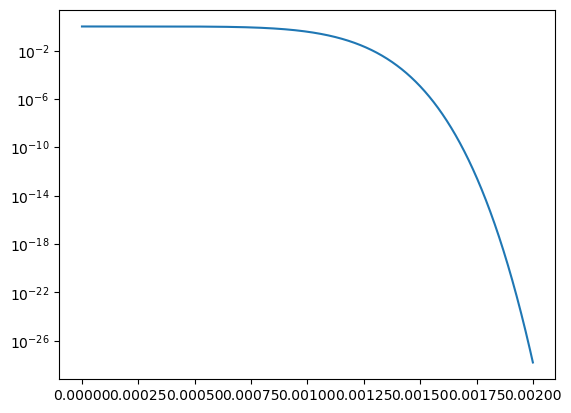

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(laser.grid.axes[0], SuperGaussianTransverseProfile(w, n_order=6).evaluate(laser.grid.axes[0], np.array([0,])))
ax.set_yscale("log")
plt.show()

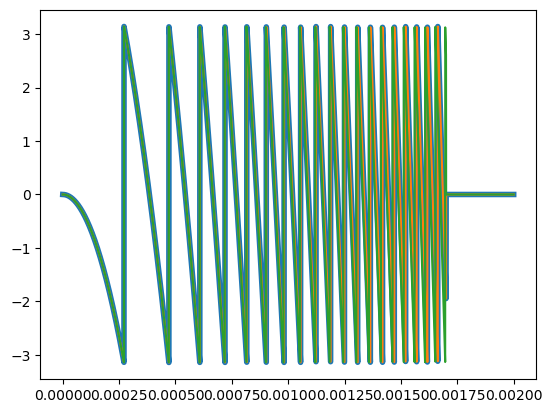

In [5]:
axiparabola = axi.Axiparabola_Ambat(f0, delta, 1.7*w)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(laser.grid.axes[0], np.angle(axiparabola.amplitude_multiplier(laser.grid.axes[0], 0, 2*np.pi*c/l_w)), lw=4)
ax.plot(laser.grid.axes[0], np.angle(np.exp(-2j * (2*np.pi*c/l_w/c)*axiparabola.R**2/4/axiparabola.delta*np.log(1+axiparabola.delta/axiparabola.f0*(laser.grid.axes[0]/axiparabola.R)**2)))*np.heaviside(1.7*w-laser.grid.axes[0], 1))
ax.plot(laser.grid.axes[0], np.angle(np.exp(-2j * (2*np.pi*c/l_w/c)*laser.grid.axes[0]**2/4/axiparabola.f0))*np.heaviside(1.7*w-laser.grid.axes[0], 1))
plt.show()

/tmp/ipykernel_202398/935201083.py:4: RuntimeWarning: invalid value encountered in divide
  ax.plot(axis, (axi.sf(axis, axiparabola) - axis**2/4/axiparabola.f0) / (axis**2/4/axiparabola.f0))


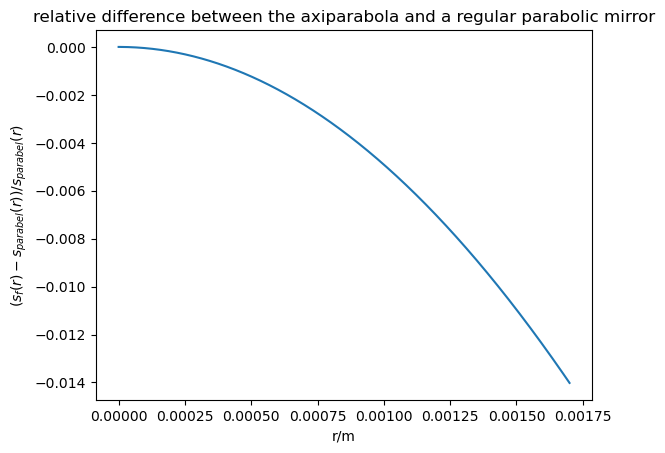

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
axis = laser.grid.axes[0][:int(npoints[0]*1.7/2)]
ax.plot(axis, (axi.sf(axis, axiparabola) - axis**2/4/axiparabola.f0) / (axis**2/4/axiparabola.f0))
ax.set_xlabel("r/m")
ax.set_ylabel("$(s_f(r) - s_{parabel}(r))/s_{parabel}(r)$")
ax.set_title("relative difference between the axiparabola and a regular parabolic mirror")
plt.show()

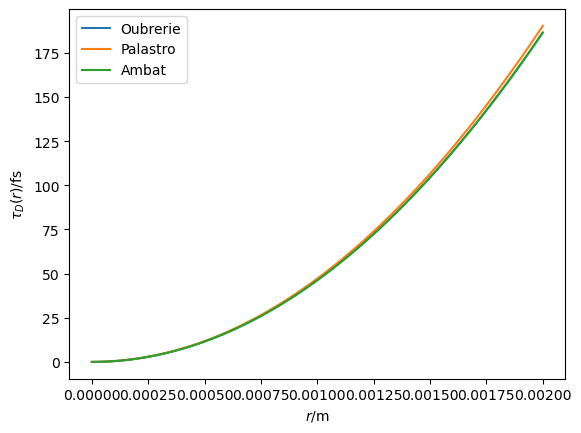

In [7]:
def tau_D(r):
    return RGD.tau_D_const_v(r, vf, axiparabola)

def tau_D2(r):
    return RGD.tau_D_integrated_palastro(r, vf, axiparabola)

def tau_D3(r):
    return RGD.tau_D_integrated_ambat(r, vf, axiparabola)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(laser.grid.axes[0], tau_D(laser.grid.axes[0])*1e15, label="Oubrerie")
ax.plot(laser.grid.axes[0], tau_D2(laser.grid.axes[0])*1e15, label="Palastro")
ax.plot(laser.grid.axes[0], tau_D3(laser.grid.axes[0])*1e15, label="Ambat")
ax.legend()
ax.set_xlabel("$r$/m")
ax.set_ylabel("$\\tau_D(r)$/fs")
plt.show()

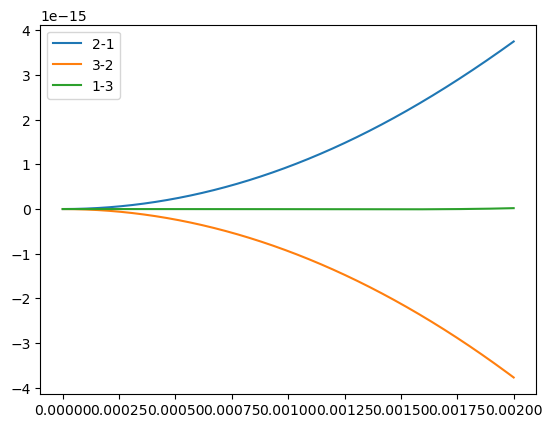

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(laser.grid.axes[0], tau_D2(laser.grid.axes[0])- tau_D(laser.grid.axes[0]), label="2-1")
ax.plot(laser.grid.axes[0], tau_D3(laser.grid.axes[0])- tau_D2(laser.grid.axes[0]), label="3-2")
ax.plot(laser.grid.axes[0], tau_D(laser.grid.axes[0])- tau_D3(laser.grid.axes[0]), label="1-3")
ax.legend()
plt.show()

In [9]:
if do_rgd:
    radial_delay = RGD.RadialGroupDelay(tau_D, l_w)
    laser.apply_optics(radial_delay)
    laser.show()
    def ztime(z):
        return (z-axiparabola.f0)/vf + axiparabola.f0/c
else:
    def ztime(z):
        r2 = (z-axiparabola.f0) / axiparabola.delta*axiparabola.R**2
        return 1/c*(z+r2/2/z-2*axiparabola.R**2/4/axiparabola.delta*np.log(1+axiparabola.delta/axiparabola.f0*r2/axiparabola.R**2))
print("time:", (time.time()-start)/60, "min")

time: 0.1542702555656433 min


time: 0.38384489218393963 min


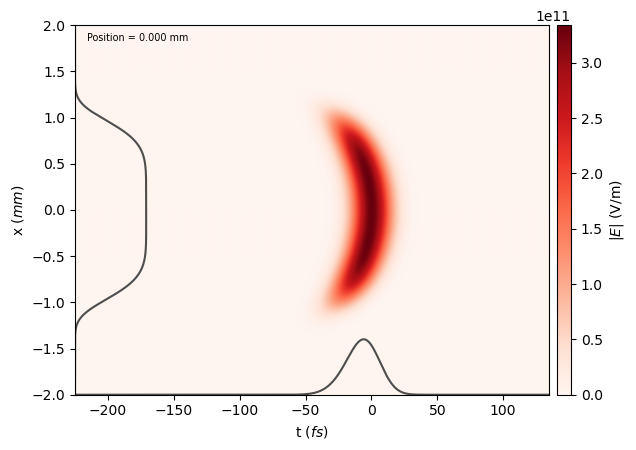

In [10]:
laser.apply_optics(axiparabola)
laser.show()
print("time:", (time.time()-start)/60, "min")

Extracting full field
Nt = 4901


  0%|          | 00:00<? [?it/s]

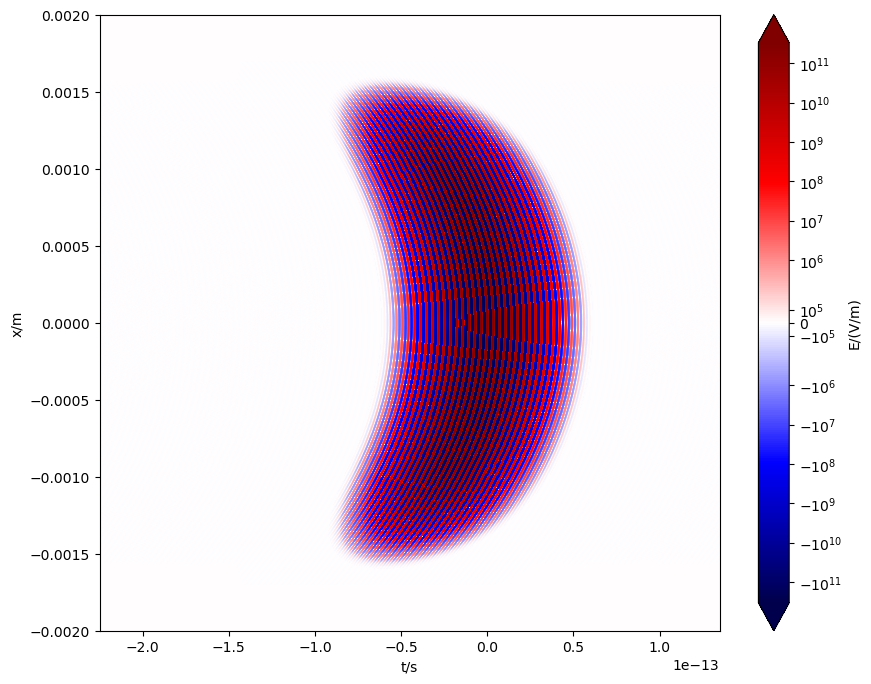

In [11]:
full_field.show_field(laser, Nt=None, Nr=None, offset_frac=2*offset_frac, forced_dt=des_dt, linthresh_frac=0.000001)

In [12]:
if dim == "xyt":
    import regrid
    laser = regrid.regrid_laser(laser, Nx=npoints_prop[0])
    laser = regrid.regrid_laser(laser, Ny=npoints_prop[1])
    laser.show()
    print("time:", (time.time()-start)/60, "min")

Available backends are: NP
NP is chosen


  0%|          | 00:00<? [?it/s]

time: 31.895312452316283 min


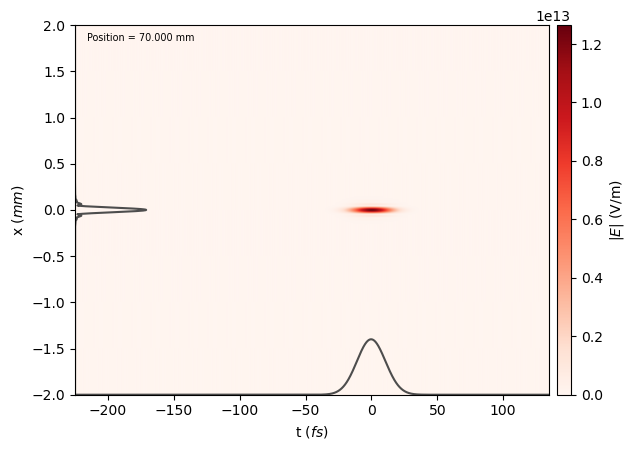

In [13]:
laser.propagate(f0)
laser.show()
print("time:", (time.time()-start)/60, "min")

Extracting full field
Offsetting by 9.374 percent of the original field


  0%|          | 00:00<? [?it/s]

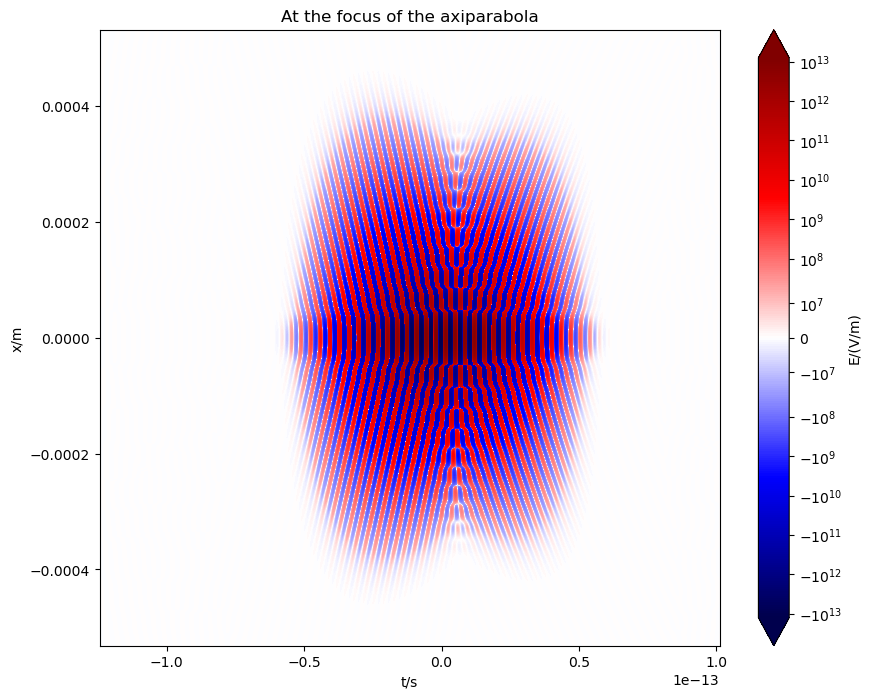

w = 3.193402877784058e-05


In [14]:
full_field.show_field(laser, Nt=3072, Nr=3000, offset_frac=1*offset_frac, forced_dt=des_dt, linthresh_frac=0.000001, title="At the focus of the axiparabola")
print("w =", get_w0(laser.grid, laser.dim))

In [14]:
if dim == "xyt":
    laser = regrid.cutgrid_laser(laser, Nx=400, Ny=400)

extracting full field...


  0%|          | 00:00<? [?it/s]

Offsetting by 9.374 percent of the original field


  0%|          | 00:00<? [?it/s]

saving...
transposing
Data type: float32
flushing


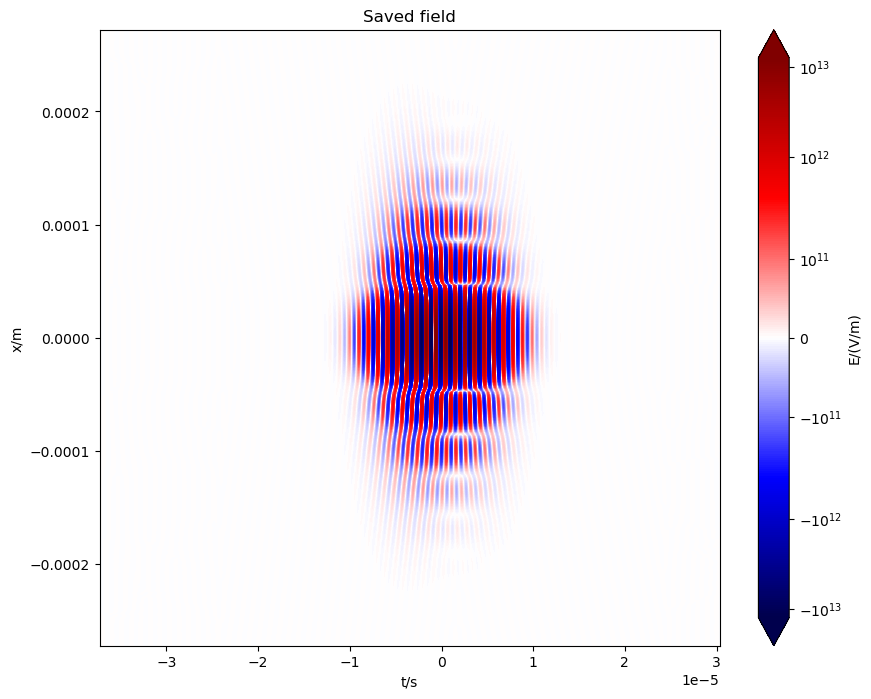

done
time: 82.03621022701263 min


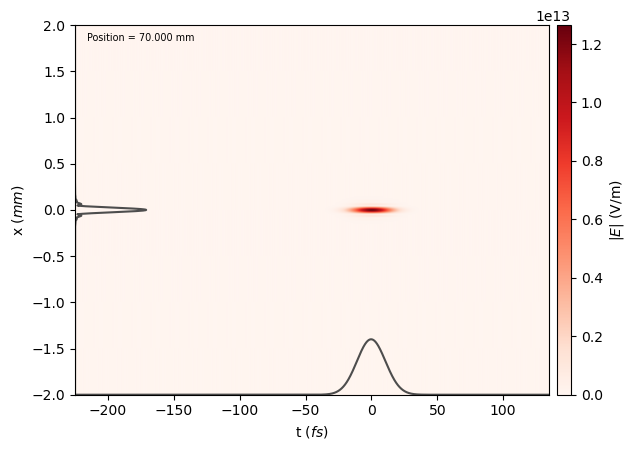

In [20]:
full_field.laser_to_openPMD(laser, "fl_foc_noRGD3", Nt=3072, Nx=int(1024/picpoints_per_p), Ny=int(1024/picpoints_per_p), conversion_safety=1.1,
                            points_between_r=p_per_r, forced_dt=des_dt, offset_frac=1*offset_frac, file_format="bp", data_step=picpoints_per_p, show=True)
laser.show()
print("time:", (time.time()-start)/60, "min")

[11286, 5000]
4.2924334437508505e-17


  0%|          | 00:00<? [?it/s]

t: -1.132075796437941e-16
t expect -1.079239001956222e-16
w: 3.2133392529236896e-05
w expect 2.3927674061305775e-05
0.07066666666666667
time: 60.62510478099187 min


  0%|          | 00:00<? [?it/s]

t: -2.2439847233661205e-16
t expect -4.2631830558825407e-16
w: 3.34830756649532e-05
w expect 1.6919420586770772e-05
0.07133333333333335
time: 88.7734299937884 min


  0%|          | 00:00<? [?it/s]

t: -3.3096890209068417e-16
t expect -9.473692763383021e-16
w: 3.5941119736901194e-05
w expect 1.3814649060376516e-05
0.07200000000000001
time: 116.76649789412816 min


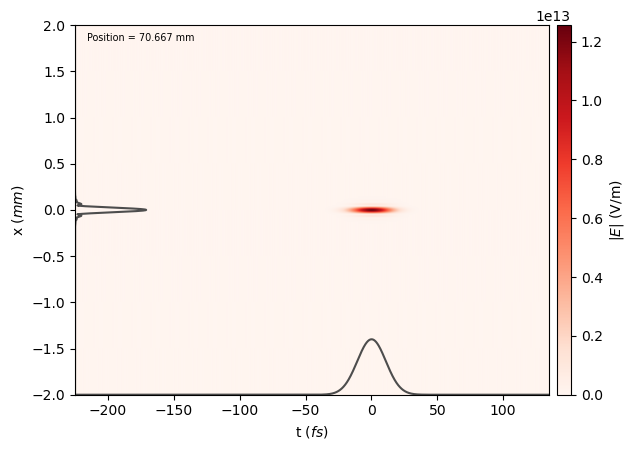

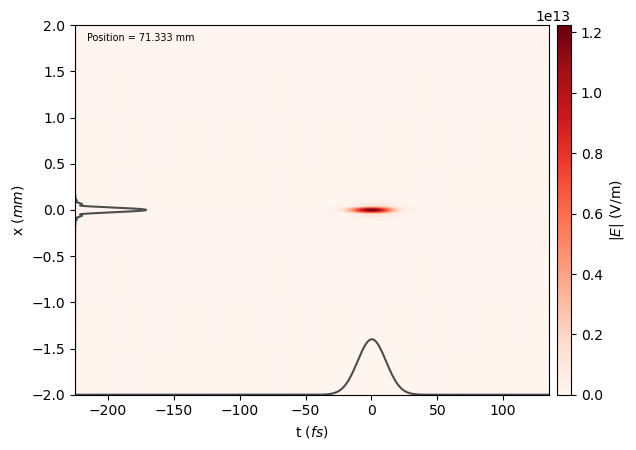

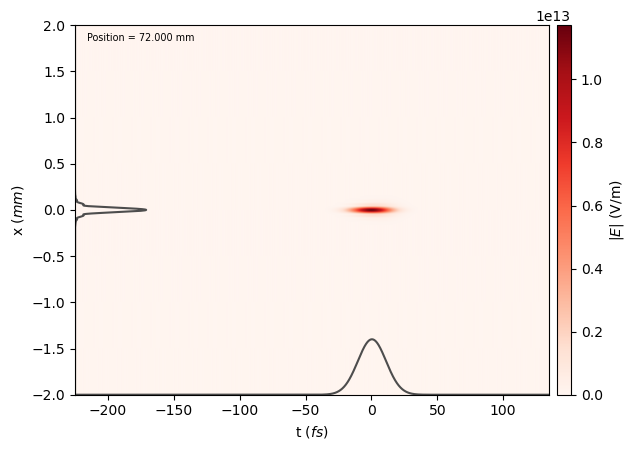

In [15]:
print(laser.grid.npoints)
tps = full_field.get_tpeak(laser)
print(tps)
for n in range(3):
    laser.propagate(delta/3)
    laser.show()
    print("t:",full_field.get_tpeak(laser)-tps)
    print("t expect", ztime(f0+(n+1)*delta/3) - (f0+(n+1)*delta/3) / c)
    print("w:",get_w0(laser.grid, laser.dim))
    print("w expect", l_w*axiparabola.f0/np.pi/axiparabola.R*np.sqrt(axiparabola.delta/((n+1)*delta/3)))
    print(f0+(n+1)*delta/3)
    print("time:", (time.time()-start)/60, "min")

In [ ]:
laser.propagate(delta)
laser.show()
print("time:", (time.time()-start)/60, "min")

In [ ]:
laser.propagate(delta)
laser.show()
print("time:", (time.time()-start)/60, "min")